============================================================================
### SECCIÓN 1: PREPARACIÓN PARA MODELADO Y EVALUACIÓN DE EQUIDAD
============================================================================

INICIANDO
CARGANDO Y PREPARANDO DATOS
Dimensiones originales: (18316, 52)
Dimensiones después de filtros: (14801, 52)
Registros eliminados: 3515

SELECCIÓN DE CARACTERÍSTICAS
Características seleccionadas (9):
   1. age                  - int64 (65 valores únicos)
   2. sex                  - object (2 valores únicos)
   3. race                 - object (6 valores únicos)
   4. priors_count         - int64 (37 valores únicos)
   5. age_cat              - object (3 valores únicos)
   6. c_charge_degree      - object (13 valores únicos)
   7. juv_fel_count        - int64 (11 valores únicos)
   8. juv_misd_count       - int64 (11 valores únicos)
   9. juv_other_count      - int64 (11 valores únicos)

Atributos sensibles: ['sex', 'race', 'age_cat']

PREPARANDO DATASETS
Forma de X: (14801, 9)
Forma de y: (14801,)

CODIFICANDO VARIABLES CATEGÓRICAS
Variables categóricas: ['sex', 'race', 'age_cat', 'c_charge_degree']
  sex: {'Female': np.int64(0), 'Male': np.int64(1)}
  race: {'African-Americ

============================================================================
### SECCIÓN 2: LIMPIEZA Y PREPROCESAMIENTO DE DATOS
============================================================================

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve)
import warnings
warnings.filterwarnings('ignore')

# Configuración para visualizaciones
plt.style.use('default')
sns.set_palette("husl")

print("INICIANDO")
print("="*50)

# CARGA Y PREPARACIÓN INICIAL DE DATOS

print("CARGANDO Y PREPARANDO DATOS")

# Cargar datos
df = pd.read_csv('data/cox-violent-parsed.csv')
print(f"Dimensiones originales: {df.shape}")

# Aplicar filtros básicos de calidad (basados en estudio ProPublica)
df_clean = df[
    (df['days_b_screening_arrest'] <= 30) &
    (df['days_b_screening_arrest'] >= -30) &
    (df['is_recid'] != -1) &
    (df['c_charge_degree'] != 'O') &
    (df['score_text'] != 'N/A')
].copy()

print(f"Dimensiones después de filtros: {df_clean.shape}")
print(f"Registros eliminados: {len(df) - len(df_clean)}")


# SELECCIÓN DE CARACTERÍSTICAS

print(f"\nSELECCIÓN DE CARACTERÍSTICAS")

# Variables para el modelo
feature_cols = [
    'age',              # Edad (numérica)
    'sex',              # Género (sensible)
    'race',             # Raza (sensible) 
    'priors_count',     # Antecedentes (numérica)
    'age_cat',          # Categoría edad (sensible)
    'c_charge_degree',  # Grado del cargo
    'juv_fel_count',    # Delitos juveniles graves
    'juv_misd_count',   # Delitos juveniles menores  
    'juv_other_count'   # Otros delitos juveniles
]

# Verificar características disponibles
available_features = [col for col in feature_cols if col in df_clean.columns]
target_col = 'is_recid'

print(f"Características seleccionadas ({len(available_features)}):")
for i, col in enumerate(available_features, 1):
    unique_vals = df_clean[col].nunique()
    dtype = df_clean[col].dtype
    print(f"  {i:2d}. {col:<20} - {dtype} ({unique_vals} valores únicos)")

# Atributos sensibles para análisis de equidad
sensitive_attributes = ['sex', 'race', 'age_cat']
print(f"\nAtributos sensibles: {sensitive_attributes}")

# PREPARAR DATASETS

print(f"\nPREPARANDO DATASETS")

# Crear matriz de características y vector objetivo
X = df_clean[available_features].copy()
y = df_clean[target_col].copy()

print(f"Forma de X: {X.shape}")
print(f"Forma de y: {y.shape}")

# Manejar valores faltantes si existen
missing_summary = X.isnull().sum()
if missing_summary.sum() > 0:
    print(f"Manejando valores faltantes:")
    for col in missing_summary[missing_summary > 0].index:
        if X[col].dtype in ['object', 'category']:
            mode_val = X[col].mode()[0]
            X[col] = X[col].fillna(mode_val)
            print(f"  {col}: rellenado con moda '{mode_val}'")
        else:
            median_val = X[col].median()
            X[col] = X[col].fillna(median_val)
            print(f"  {col}: rellenado con mediana {median_val}")

# CODIFICACIÓN DE VARIABLES CATEGÓRICAS

print(f"\nCODIFICANDO VARIABLES CATEGÓRICAS")

# Identificar variables categóricas
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Variables categóricas: {categorical_cols}")

# Aplicar Label Encoding y guardar encoders
le_dict = {}
for col in categorical_cols:
    le_dict[col] = LabelEncoder()
    X[col] = le_dict[col].fit_transform(X[col].astype(str))
    
    # Mostrar mapeo
    mapping = dict(zip(le_dict[col].classes_, le_dict[col].transform(le_dict[col].classes_)))
    print(f"  {col}: {mapping}")

# DIVISIÓN ESTRATIFICADA TRAIN/TEST

print(f"\nDIVISIÓN TRAIN/TEST")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Entrenamiento: {X_train.shape}")
print(f"Prueba: {X_test.shape}")

# Verificar balance de clases
print(f"\nDistribución de clases:")
print("Entrenamiento:", y_train.value_counts(normalize=True).round(3).to_dict())
print("Prueba:", y_test.value_counts(normalize=True).round(3).to_dict())

# ESTANDARIZACIÓN

print(f"\nESTANDARIZACIÓN DE CARACTERÍSTICAS")

# Características numéricas para estandarizar
numeric_cols = ['age', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count']
available_numeric = [col for col in numeric_cols if col in X_train.columns]

print(f"Características numéricas: {available_numeric}")

# Crear copias y aplicar StandardScaler
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

if available_numeric:
    scaler = StandardScaler()
    X_train_scaled[available_numeric] = scaler.fit_transform(X_train[available_numeric])
    X_test_scaled[available_numeric] = scaler.transform(X_test[available_numeric])
    print("Estandarización aplicada")
else:
    scaler = None
    print("No hay características numéricas para estandarizar")

# Guardar versiones originales para análisis de equidad
X_train_orig = X_train.copy()
X_test_orig = X_test.copy()

print(f"\nPREPARACIÓN COMPLETADA")
print(f"Variables disponibles:")
print(f"  - X_train_scaled, X_test_scaled: datos estandarizados")
print(f"  - X_train_orig, X_test_orig: datos originales")  
print(f"  - y_train, y_test: variables objetivo")

INICIANDO
CARGANDO Y PREPARANDO DATOS
Dimensiones originales: (18316, 52)
Dimensiones después de filtros: (14801, 52)
Registros eliminados: 3515

SELECCIÓN DE CARACTERÍSTICAS
Características seleccionadas (9):
   1. age                  - int64 (65 valores únicos)
   2. sex                  - object (2 valores únicos)
   3. race                 - object (6 valores únicos)
   4. priors_count         - int64 (37 valores únicos)
   5. age_cat              - object (3 valores únicos)
   6. c_charge_degree      - object (13 valores únicos)
   7. juv_fel_count        - int64 (11 valores únicos)
   8. juv_misd_count       - int64 (11 valores únicos)
   9. juv_other_count      - int64 (11 valores únicos)

Atributos sensibles: ['sex', 'race', 'age_cat']

PREPARANDO DATASETS
Forma de X: (14801, 9)
Forma de y: (14801,)

CODIFICANDO VARIABLES CATEGÓRICAS
Variables categóricas: ['sex', 'race', 'age_cat', 'c_charge_degree']
  sex: {'Female': np.int64(0), 'Male': np.int64(1)}
  race: {'African-Americ

============================================================================
### SECCIÓN 2: ENTRENAMIENTO DE MODELOS BASE
============================================================================

ENTRENAMIENTO DE MODELOS BASE
1️⃣ DEFINIENDO Y ENTRENANDO MODELOS

Entrenando Logistic Regression...
  Accuracy (Test): 0.659
  Precision (Test): 0.654
  Recall (Test): 0.646
  F1-Score (Test): 0.650
  AUC (Test): 0.715

Entrenando Decision Tree...
  Accuracy (Test): 0.674
  Precision (Test): 0.670
  Recall (Test): 0.662
  F1-Score (Test): 0.666
  AUC (Test): 0.734

Entrenando Random Forest...
  Accuracy (Test): 0.684
  Precision (Test): 0.665
  Recall (Test): 0.717
  F1-Score (Test): 0.690
  AUC (Test): 0.760

Entrenamiento completado

2️COMPARACIÓN DE RENDIMIENTO

TABLA DE COMPARACIÓN:


,Accuracy,Precision,Recall,F1-Score,AUC
Modelo,,,,,
Logistic Regression,0.659,0.654,0.646,0.650,0.715
Decision Tree,0.674,0.670,0.662,0.666,0.734
Random Forest,0.684,0.665,0.717,0.690,0.760



MEJORES MODELOS POR MÉTRICA:
  Accuracy: Random Forest (0.684)
  Precision: Decision Tree (0.670)
  Recall: Random Forest (0.717)
  F1-Score: Random Forest (0.690)
  AUC: Random Forest (0.760)

3️VISUALIZACIÓN DE RESULTADOS


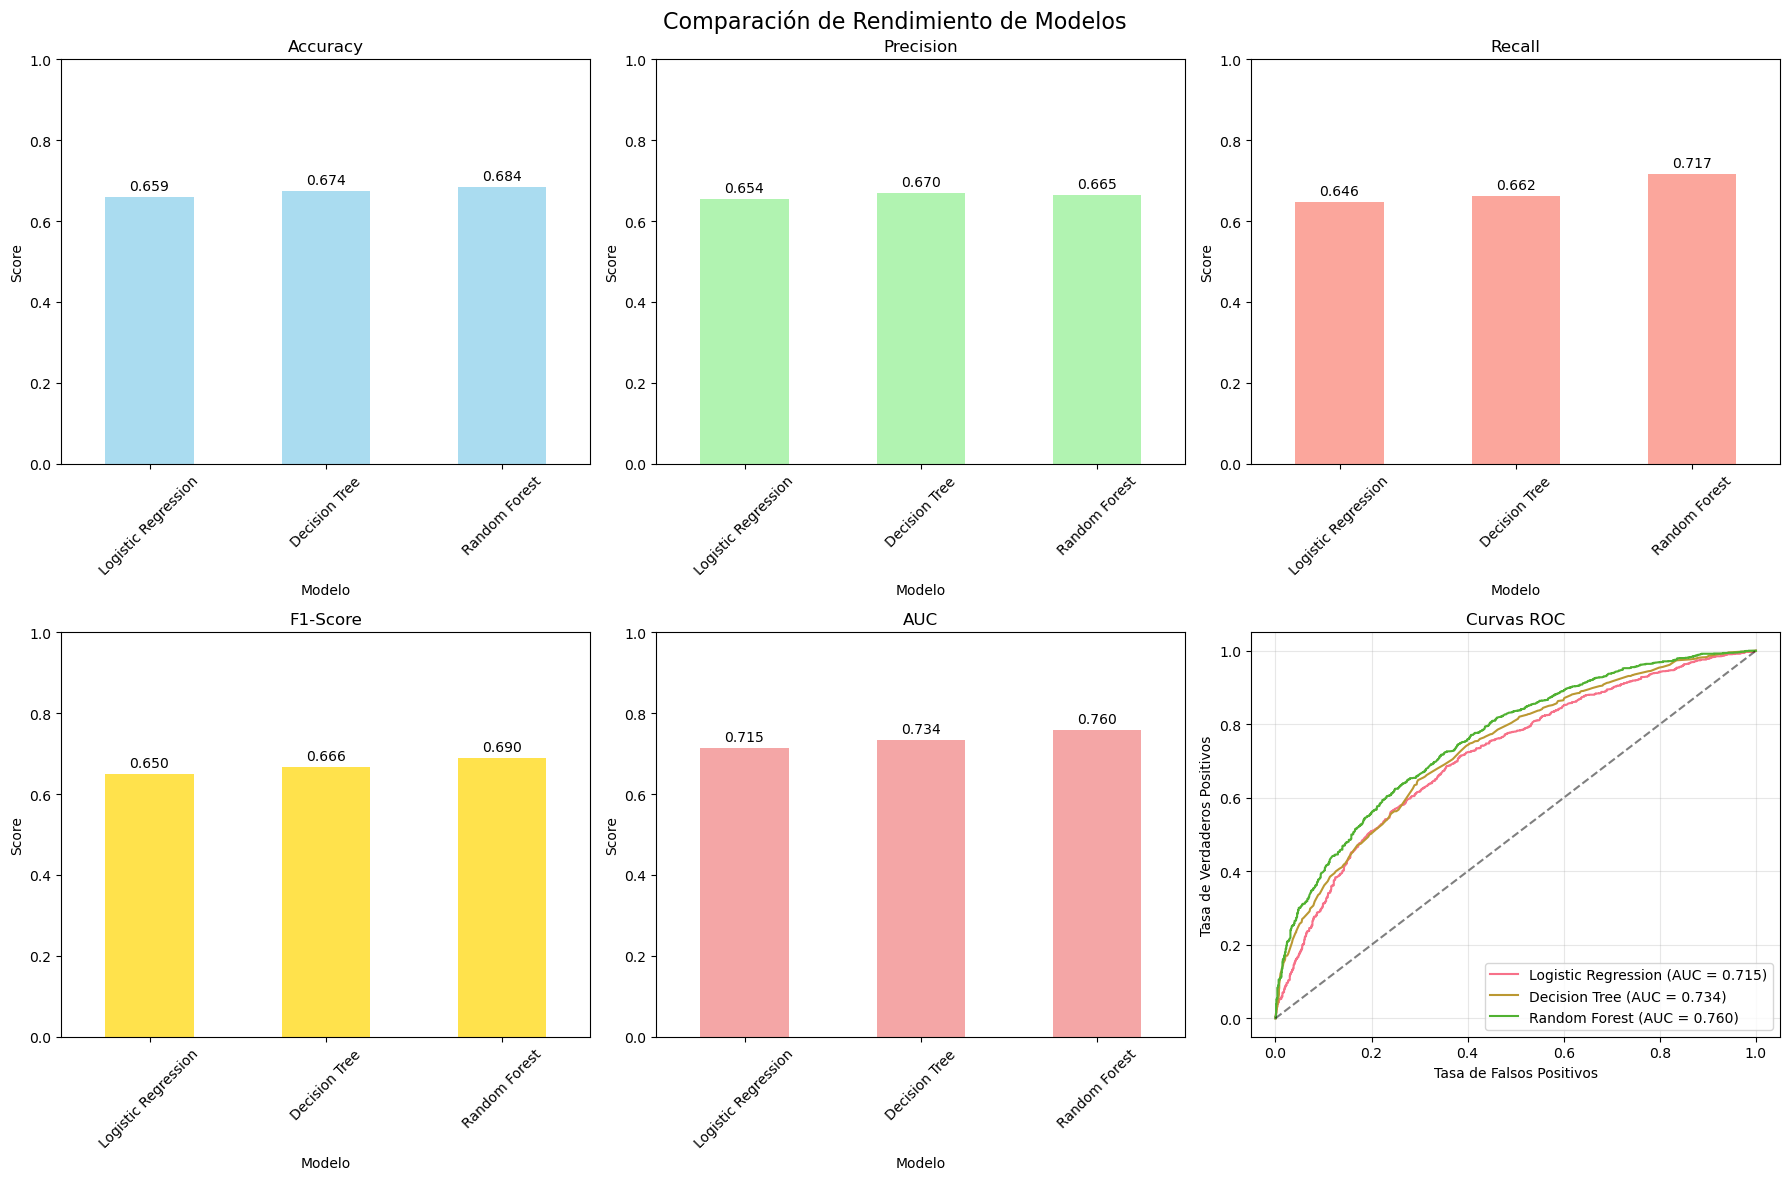


4️ MATRICES DE CONFUSIÓN


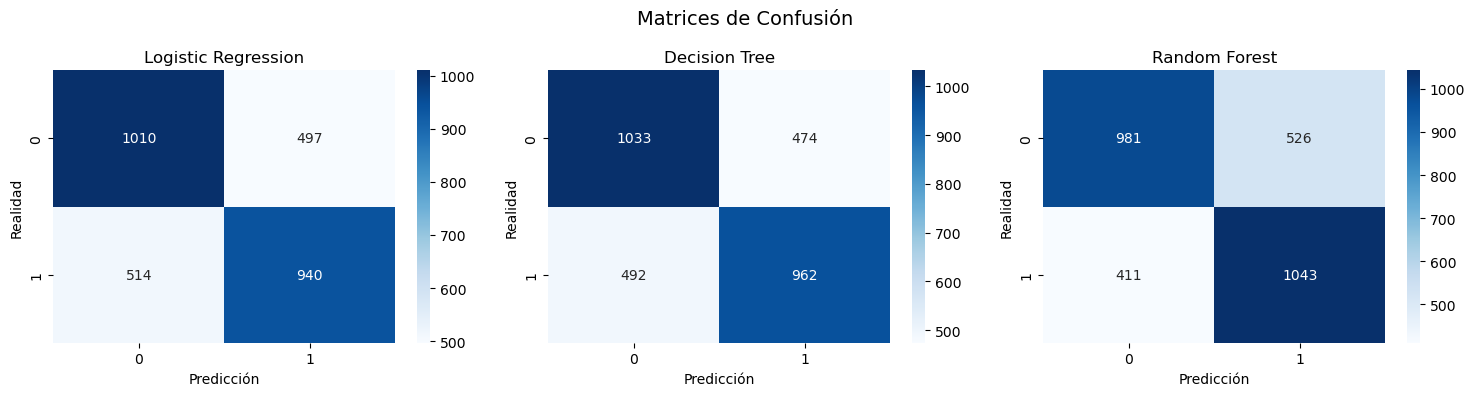


5️ REPORTES DE CLASIFICACIÓN DETALLADOS

==================== Logistic Regression ====================
MÉTRICAS POR CLASE:
Clase 0 (No Reincide):
  Precision: 0.663
  Recall: 0.670
  F1-Score: 0.666
Clase 1 (Reincide):
  Precision: 0.654
  Recall: 0.646
  F1-Score: 0.650
MÉTRICAS GLOBALES:
  Accuracy: 0.659
  Macro Avg F1: 0.658
  Weighted Avg F1: 0.659

==================== Decision Tree ====================
MÉTRICAS POR CLASE:
Clase 0 (No Reincide):
  Precision: 0.677
  Recall: 0.685
  F1-Score: 0.681
Clase 1 (Reincide):
  Precision: 0.670
  Recall: 0.662
  F1-Score: 0.666
MÉTRICAS GLOBALES:
  Accuracy: 0.674
  Macro Avg F1: 0.674
  Weighted Avg F1: 0.674

==================== Random Forest ====================
MÉTRICAS POR CLASE:
Clase 0 (No Reincide):
  Precision: 0.705
  Recall: 0.651
  F1-Score: 0.677
Clase 1 (Reincide):
  Precision: 0.665
  Recall: 0.717
  F1-Score: 0.690
MÉTRICAS GLOBALES:
  Accuracy: 0.684
  Macro Avg F1: 0.683
  Weighted Avg F1: 0.683

6️ ANÁLISIS DE SOBREAJ

,Train_Acc,Test_Acc,Acc_Diff,Train_AUC,Test_AUC,AUC_Diff
Modelo,,,,,,
Logistic Regression,0.663,0.659,0.005,0.714,0.715,-0.000
Decision Tree,0.711,0.674,0.037,0.791,0.734,0.057
Random Forest,0.711,0.684,0.027,0.798,0.760,0.038



INTERPRETACIÓN:
 Logistic Regression: Buen balance train/test
 Decision Tree: Posible sobreajuste (diff_acc: 0.037, diff_auc: 0.057)
 Random Forest: Buen balance train/test

 MODELADO BASE COMPLETADO
Variables creadas:
  - trained_models: diccionario con modelos entrenados
  - model_results: diccionario con métricas y predicciones
  - comparison_df: DataFrame con comparación de métricas


In [16]:
print("ENTRENAMIENTO DE MODELOS BASE")
print("="*50)

# DEFINICIÓN Y ENTRENAMIENTO DE MODELOS

print("1️⃣ DEFINIENDO Y ENTRENANDO MODELOS")

# Definir modelos con hiperparámetros optimizados
models = {
    'Logistic Regression': LogisticRegression(
        random_state=42, 
        max_iter=1000,
        solver='lbfgs',
        C=1.0
    ),
    'Decision Tree': DecisionTreeClassifier(
        random_state=42, 
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10
    ),
    'Random Forest': RandomForestClassifier(
        random_state=42, 
        n_estimators=100,
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=5
    )
}

# Entrenar modelos y guardar resultados
trained_models = {}
model_results = {}

for name, model in models.items():
    print(f"\nEntrenando {name}...")
    
    # Entrenar modelo
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    
    # Hacer predicciones
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    y_prob_train = model.predict_proba(X_train_scaled)[:, 1]
    y_prob_test = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calcular métricas
    results = {
        # Métricas de entrenamiento
        'train_accuracy': accuracy_score(y_train, y_pred_train),
        'train_precision': precision_score(y_train, y_pred_train),
        'train_recall': recall_score(y_train, y_pred_train),
        'train_f1': f1_score(y_train, y_pred_train),
        'train_auc': roc_auc_score(y_train, y_prob_train),
        
        # Métricas de prueba
        'test_accuracy': accuracy_score(y_test, y_pred_test),
        'test_precision': precision_score(y_test, y_pred_test),
        'test_recall': recall_score(y_test, y_pred_test),
        'test_f1': f1_score(y_test, y_pred_test),
        'test_auc': roc_auc_score(y_test, y_prob_test),
        
        # Predicciones para análisis posterior
        'y_pred_test': y_pred_test,
        'y_prob_test': y_prob_test
    }
    
    model_results[name] = results
    
    # Mostrar métricas principales
    print(f"  Accuracy (Test): {results['test_accuracy']:.3f}")
    print(f"  Precision (Test): {results['test_precision']:.3f}")
    print(f"  Recall (Test): {results['test_recall']:.3f}")
    print(f"  F1-Score (Test): {results['test_f1']:.3f}")
    print(f"  AUC (Test): {results['test_auc']:.3f}")

print(f"\nEntrenamiento completado")

# COMPARACIÓN DE RENDIMIENTO

print(f"\n2️COMPARACIÓN DE RENDIMIENTO")

# Crear DataFrame para comparación
metrics_comparison = []
for name, results in model_results.items():
    metrics_comparison.append({
        'Modelo': name,
        'Accuracy': results['test_accuracy'],
        'Precision': results['test_precision'],
        'Recall': results['test_recall'],
        'F1-Score': results['test_f1'],
        'AUC': results['test_auc']
    })

comparison_df = pd.DataFrame(metrics_comparison).set_index('Modelo')
print("\nTABLA DE COMPARACIÓN:")
display(comparison_df.round(3))

# Identificar mejor modelo por métrica
print(f"\nMEJORES MODELOS POR MÉTRICA:")
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']:
    best_model = comparison_df[metric].idxmax()
    best_value = comparison_df.loc[best_model, metric]
    print(f"  {metric}: {best_model} ({best_value:.3f})")

# VISUALIZACIÓN DE RESULTADOS

print(f"\n3️VISUALIZACIÓN DE RESULTADOS")

# Gráfico de barras comparativo
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comparación de Rendimiento de Modelos', fontsize=16)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'lightcoral']

for i, metric in enumerate(metrics):
    row = i // 3
    col = i % 3
    
    ax = axes[row, col]
    comparison_df[metric].plot(kind='bar', ax=ax, color=colors[i], alpha=0.7)
    ax.set_title(f'{metric}')
    ax.set_ylabel('Score')
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(0, 1)
    
    # Agregar valores en las barras
    for j, v in enumerate(comparison_df[metric]):
        ax.text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# ROC Curves
ax = axes[1, 2]
for name, results in model_results.items():
    y_prob = results['y_prob_test']
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = results['test_auc']
    ax.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax.set_xlabel('Tasa de Falsos Positivos')
ax.set_ylabel('Tasa de Verdaderos Positivos')
ax.set_title('Curvas ROC')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# MATRICES DE CONFUSIÓN

print(f"\n4️ MATRICES DE CONFUSIÓN")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Matrices de Confusión', fontsize=14)

for i, (name, results) in enumerate(model_results.items()):
    y_pred = results['y_pred_test']
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{name}')
    axes[i].set_xlabel('Predicción')
    axes[i].set_ylabel('Realidad')

plt.tight_layout()
plt.show()

# REPORTES DE CLASIFICACIÓN DETALLADOS

print(f"\n5️ REPORTES DE CLASIFICACIÓN DETALLADOS")

for name, results in model_results.items():
    print(f"\n{'='*20} {name} {'='*20}")
    y_pred = results['y_pred_test']
    report = classification_report(y_test, y_pred, output_dict=True)
    
    print(f"MÉTRICAS POR CLASE:")
    print(f"Clase 0 (No Reincide):")
    print(f"  Precision: {report['0']['precision']:.3f}")
    print(f"  Recall: {report['0']['recall']:.3f}")
    print(f"  F1-Score: {report['0']['f1-score']:.3f}")
    
    print(f"Clase 1 (Reincide):")
    print(f"  Precision: {report['1']['precision']:.3f}")
    print(f"  Recall: {report['1']['recall']:.3f}")
    print(f"  F1-Score: {report['1']['f1-score']:.3f}")
    
    print(f"MÉTRICAS GLOBALES:")
    print(f"  Accuracy: {report['accuracy']:.3f}")
    print(f"  Macro Avg F1: {report['macro avg']['f1-score']:.3f}")
    print(f"  Weighted Avg F1: {report['weighted avg']['f1-score']:.3f}")

# ANÁLISIS DE SOBREAJUSTE

print(f"\n6️ ANÁLISIS DE SOBREAJUSTE")

overfit_analysis = []
for name, results in model_results.items():
    train_acc = results['train_accuracy']
    test_acc = results['test_accuracy']
    train_auc = results['train_auc']
    test_auc = results['test_auc']
    
    acc_diff = train_acc - test_acc
    auc_diff = train_auc - test_auc
    
    overfit_analysis.append({
        'Modelo': name,
        'Train_Acc': train_acc,
        'Test_Acc': test_acc,
        'Acc_Diff': acc_diff,
        'Train_AUC': train_auc,
        'Test_AUC': test_auc,
        'AUC_Diff': auc_diff
    })

overfit_df = pd.DataFrame(overfit_analysis).set_index('Modelo')
print("\nANÁLISIS DE SOBREAJUSTE:")
display(overfit_df.round(3))

print(f"\nINTERPRETACIÓN:")
for name, row in overfit_df.iterrows():
    acc_diff = row['Acc_Diff']
    auc_diff = row['AUC_Diff']
    
    if acc_diff > 0.05 or auc_diff > 0.05:
        print(f" {name}: Posible sobreajuste (diff_acc: {acc_diff:.3f}, diff_auc: {auc_diff:.3f})")
    else:
        print(f" {name}: Buen balance train/test")

print(f"\n MODELADO BASE COMPLETADO")
print(f"Variables creadas:")
print(f"  - trained_models: diccionario con modelos entrenados")
print(f"  - model_results: diccionario con métricas y predicciones")
print(f"  - comparison_df: DataFrame con comparación de métricas")

============================================================================
### SECCIÓN 3: EVALUACIÓN DE SESGOS Y MÉTRICAS DE EQUIDAD
============================================================================

EVALUACIÓN DE SESGOS Y EQUIDAD
1PREPARANDO ANÁLISIS DE EQUIDAD
Atributos sensibles analizados: ['sex', 'race', 'age_cat']
Tamaño conjunto de prueba: 2961
Datos preparados correctamente

2️ ANÁLISIS DE EQUIDAD POR MODELO

==================== Logistic Regression ====================

 ANÁLISIS POR SEX:


,count,accuracy,precision,recall,positive_rate,base_rate
Female,509.0,0.666,0.663,0.279,0.163,0.387
Male,2452.0,0.657,0.654,0.704,0.552,0.513



MÉTRICAS DE DISPARIDAD:
  Disparidad en Accuracy: 0.009 (ratio: 1.01)
  Disparidad en Positive Rate: 0.389 (ratio: 3.39)
  Disparidad en TPR: 0.425 (ratio: 2.52)
  Disparidad en FPR: 0.303 (ratio: 4.37)
ALTO SESGO detectado (disparidad máxima: 0.425)

 ANÁLISIS POR RACE:


,count,accuracy,precision,recall,positive_rate,base_rate
Caucasian,972.0,0.641,0.622,0.456,0.321,0.437
African-American,1605.0,0.670,0.674,0.781,0.640,0.553
Hispanic,203.0,0.640,0.414,0.381,0.286,0.310
Other,161.0,0.652,0.742,0.324,0.193,0.441
Native American,7.0,1.000,1.000,1.000,0.429,0.429
Asian,13.0,0.692,0.600,0.600,0.385,0.385



MÉTRICAS DE DISPARIDAD:
  Disparidad en Accuracy: 0.360 (ratio: 1.56)
  Disparidad en Positive Rate: 0.448 (ratio: 3.33)
  Disparidad en TPR: 0.676 (ratio: 3.09)
  Disparidad en FPR: 0.467 (ratio: inf)
ALTO SESGO detectado (disparidad máxima: 0.676)

 ANÁLISIS POR AGE_CAT:


,count,accuracy,precision,recall,positive_rate,base_rate
Greater than 45,558.0,0.690,0.698,0.370,0.208,0.392
25 - 45,1677.0,0.673,0.696,0.592,0.418,0.491
Less than 25,726.0,0.602,0.598,0.903,0.854,0.566



MÉTRICAS DE DISPARIDAD:
  Disparidad en Accuracy: 0.088 (ratio: 1.15)
  Disparidad en Positive Rate: 0.646 (ratio: 4.11)
  Disparidad en TPR: 0.533 (ratio: 2.44)
  Disparidad en FPR: 0.687 (ratio: 7.66)
ALTO SESGO detectado (disparidad máxima: 0.646)

==================== Decision Tree ====================

 ANÁLISIS POR SEX:


,count,accuracy,precision,recall,positive_rate,base_rate
Female,509.0,0.692,0.620,0.523,0.326,0.387
Male,2452.0,0.670,0.676,0.683,0.518,0.513



MÉTRICAS DE DISPARIDAD:
  Disparidad en Accuracy: 0.021 (ratio: 1.03)
  Disparidad en Positive Rate: 0.192 (ratio: 1.59)
  Disparidad en TPR: 0.161 (ratio: 1.31)
  Disparidad en FPR: 0.142 (ratio: 1.70)
ALTO SESGO detectado (disparidad máxima: 0.192)

 ANÁLISIS POR RACE:


,count,accuracy,precision,recall,positive_rate,base_rate
Caucasian,972.0,0.671,0.645,0.551,0.373,0.437
African-American,1605.0,0.672,0.690,0.736,0.589,0.553
Hispanic,203.0,0.665,0.465,0.524,0.350,0.310
Other,161.0,0.702,0.735,0.507,0.304,0.441
Native American,7.0,0.714,0.667,0.667,0.429,0.429
Asian,13.0,0.923,1.000,0.800,0.308,0.385



MÉTRICAS DE DISPARIDAD:
  Disparidad en Accuracy: 0.258 (ratio: 1.39)
  Disparidad en Positive Rate: 0.285 (ratio: 1.94)
  Disparidad en TPR: 0.293 (ratio: 1.58)
  Disparidad en FPR: 0.408 (ratio: inf)
ALTO SESGO detectado (disparidad máxima: 0.293)

 ANÁLISIS POR AGE_CAT:


,count,accuracy,precision,recall,positive_rate,base_rate
Greater than 45,558.0,0.685,0.603,0.575,0.375,0.392
25 - 45,1677.0,0.688,0.683,0.678,0.488,0.491
Less than 25,726.0,0.634,0.677,0.674,0.563,0.566



MÉTRICAS DE DISPARIDAD:
  Disparidad en Accuracy: 0.054 (ratio: 1.09)
  Disparidad en Positive Rate: 0.189 (ratio: 1.50)
  Disparidad en TPR: 0.103 (ratio: 1.18)
  Disparidad en FPR: 0.174 (ratio: 1.71)
ALTO SESGO detectado (disparidad máxima: 0.189)

==================== Random Forest ====================

 ANÁLISIS POR SEX:


,count,accuracy,precision,recall,positive_rate,base_rate
Female,509.0,0.695,0.631,0.513,0.314,0.387
Male,2452.0,0.681,0.669,0.749,0.575,0.513



MÉTRICAS DE DISPARIDAD:
  Disparidad en Accuracy: 0.014 (ratio: 1.02)
  Disparidad en Positive Rate: 0.260 (ratio: 1.83)
  Disparidad en TPR: 0.237 (ratio: 1.46)
  Disparidad en FPR: 0.202 (ratio: 2.07)
ALTO SESGO detectado (disparidad máxima: 0.260)

 ANÁLISIS POR RACE:


,count,accuracy,precision,recall,positive_rate,base_rate
Caucasian,972.0,0.663,0.625,0.572,0.400,0.437
African-American,1605.0,0.692,0.687,0.815,0.656,0.553
Hispanic,203.0,0.665,0.460,0.460,0.310,0.310
Other,161.0,0.720,0.732,0.577,0.348,0.441
Native American,7.0,0.857,0.750,1.000,0.571,0.429
Asian,13.0,0.923,1.000,0.800,0.308,0.385



MÉTRICAS DE DISPARIDAD:
  Disparidad en Accuracy: 0.261 (ratio: 1.39)
  Disparidad en Positive Rate: 0.348 (ratio: 2.13)
  Disparidad en TPR: 0.540 (ratio: 2.17)
  Disparidad en FPR: 0.460 (ratio: inf)
ALTO SESGO detectado (disparidad máxima: 0.540)

 ANÁLISIS POR AGE_CAT:


,count,accuracy,precision,recall,positive_rate,base_rate
Greater than 45,558.0,0.713,0.669,0.534,0.314,0.392
25 - 45,1677.0,0.691,0.678,0.706,0.512,0.491
Less than 25,726.0,0.643,0.642,0.837,0.738,0.566



MÉTRICAS DE DISPARIDAD:
  Disparidad en Accuracy: 0.070 (ratio: 1.11)
  Disparidad en Positive Rate: 0.425 (ratio: 2.35)
  Disparidad en TPR: 0.303 (ratio: 1.57)
  Disparidad en FPR: 0.438 (ratio: 3.56)
ALTO SESGO detectado (disparidad máxima: 0.425)

3️ VISUALIZACIÓN DE MÉTRICAS DE EQUIDAD

Gráficos para sex


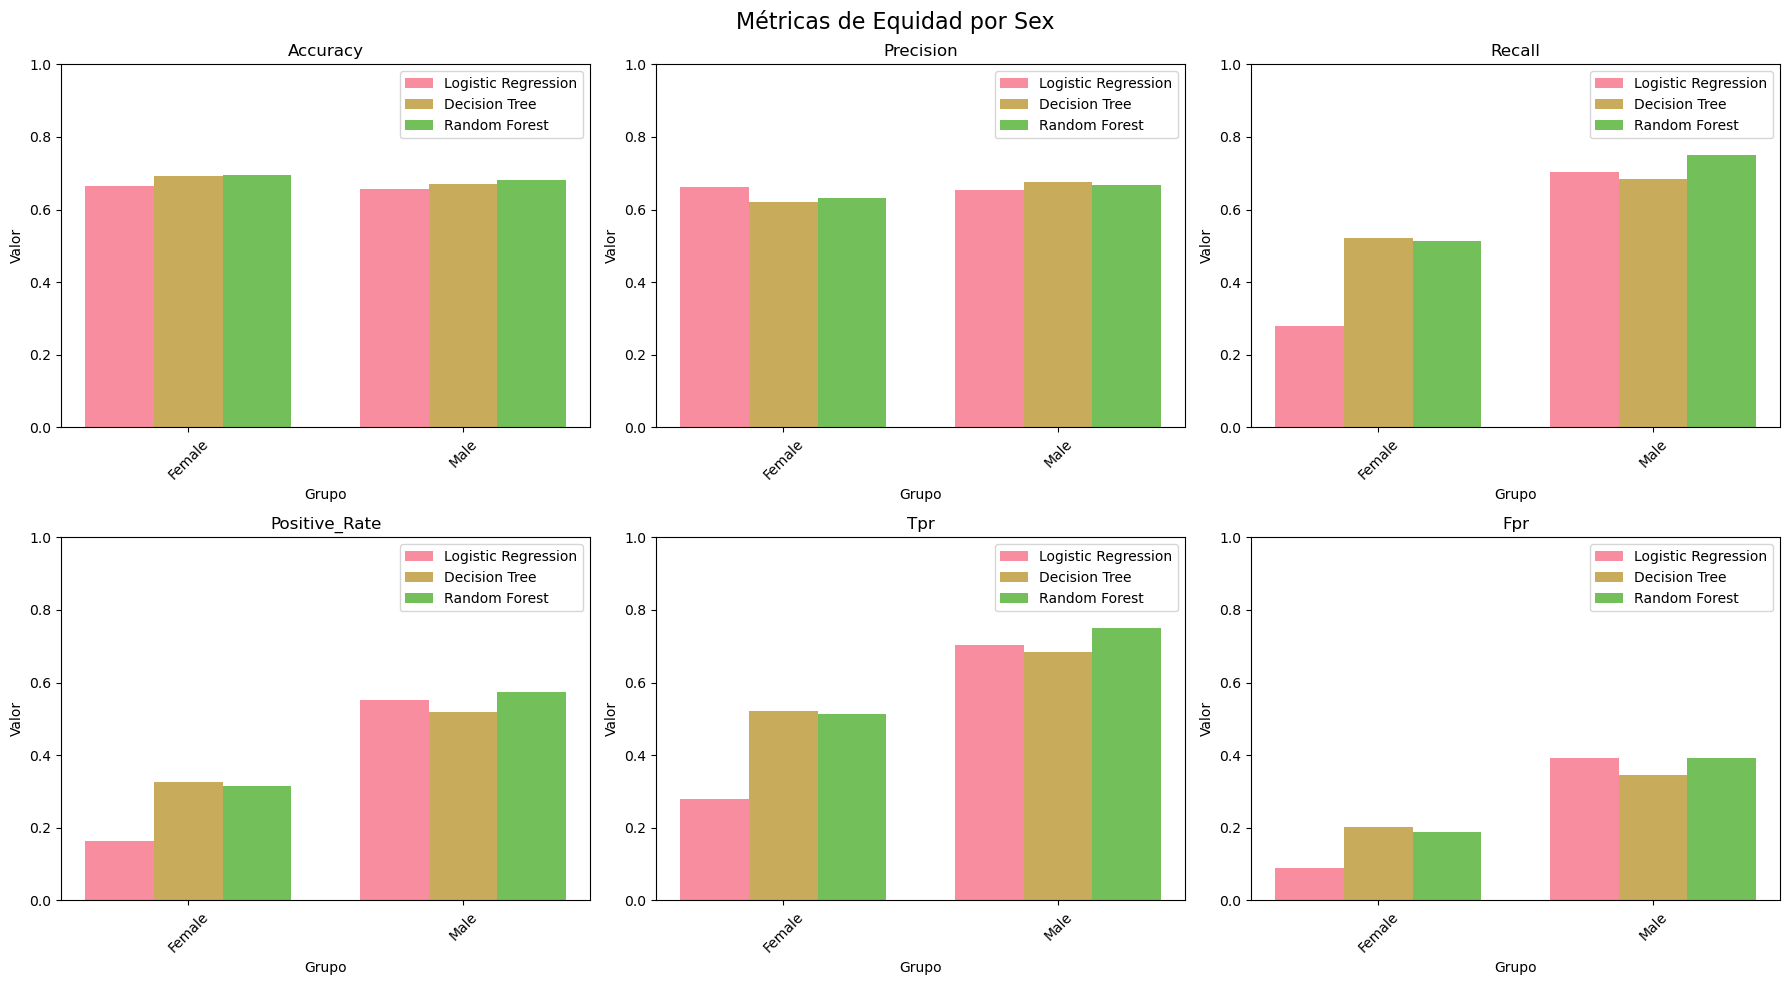


Gráficos para race


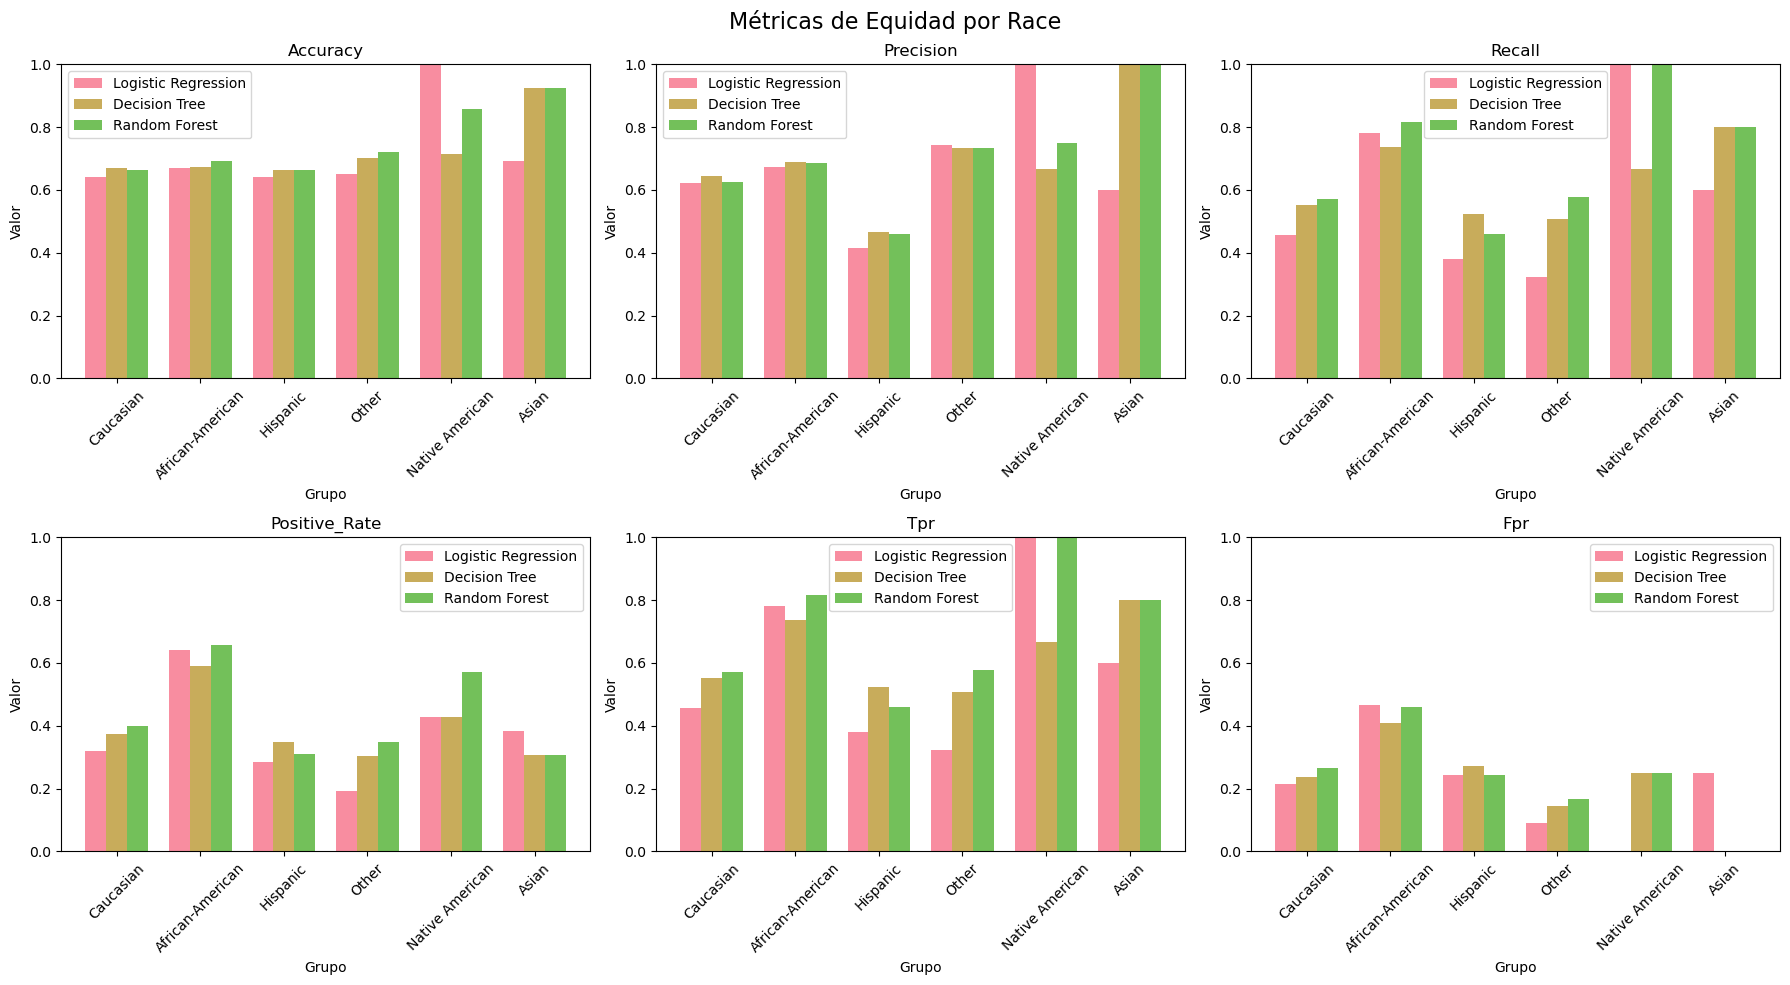


Gráficos para age_cat


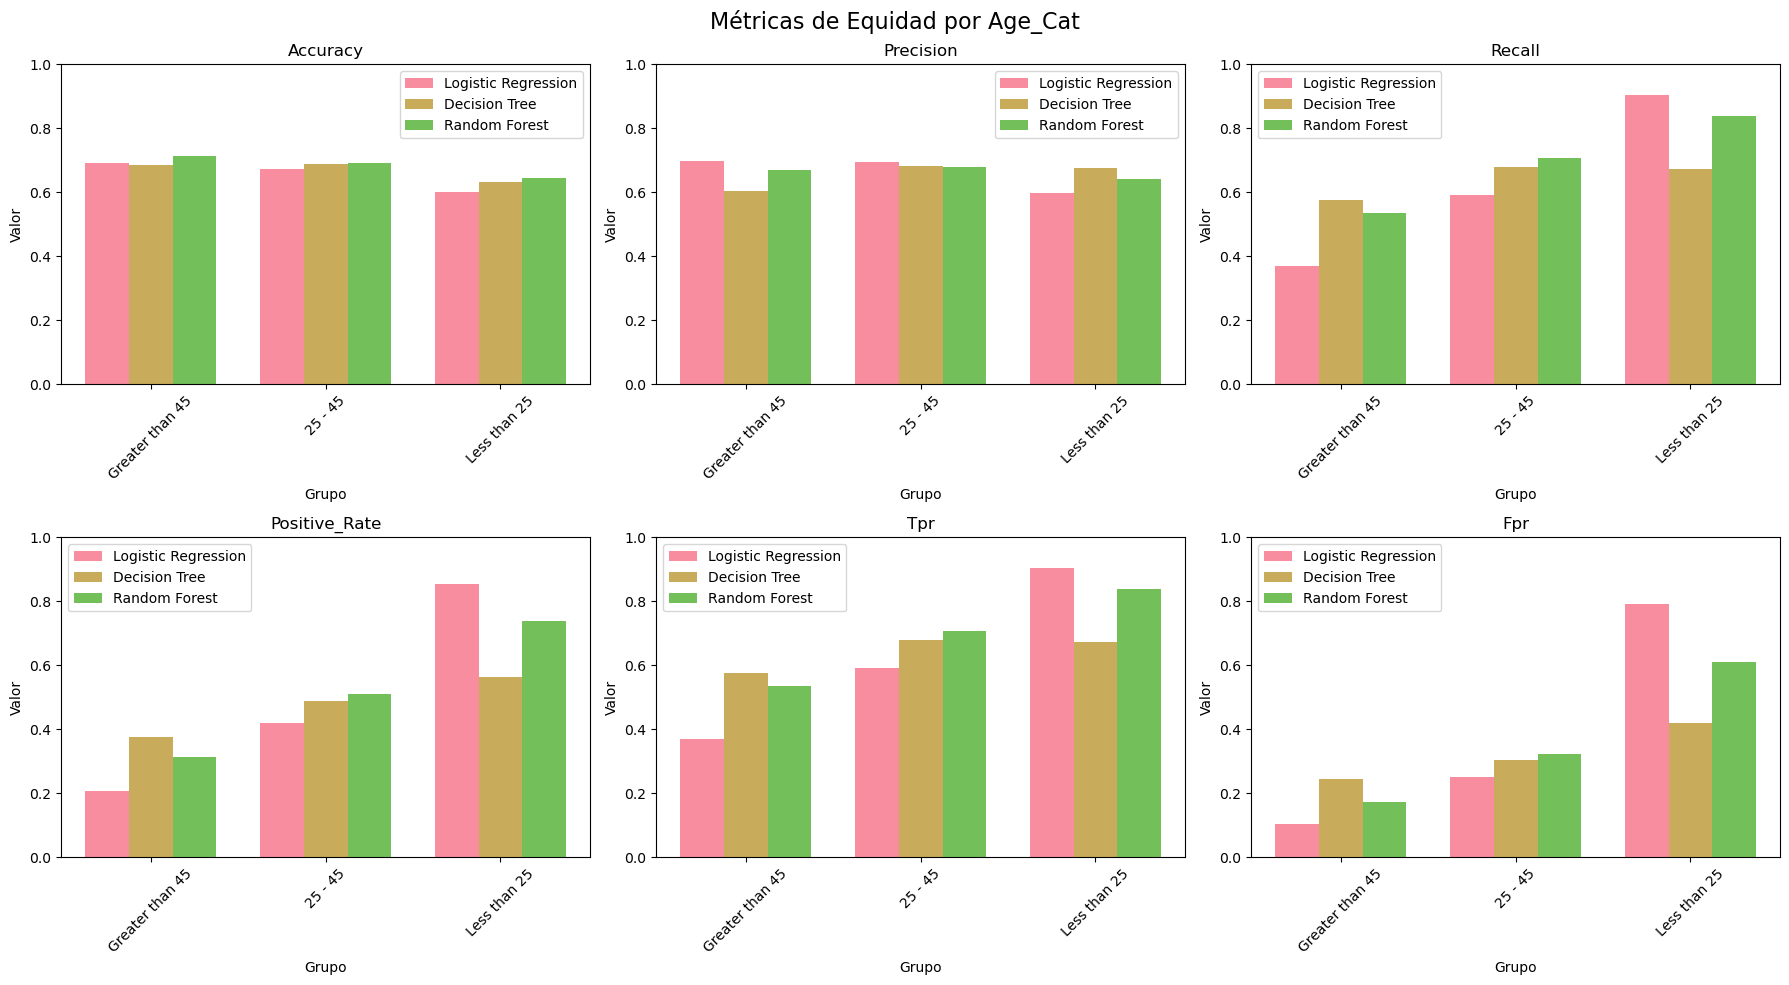


4️ TABLA RESUMEN DE DISPARIDADES


,Modelo,Atributo,Accuracy_Diff,Accuracy_Ratio,PositiveRate_Diff,PositiveRate_Ratio,TPR_Diff,TPR_Ratio,FPR_Diff,FPR_Ratio
0,Logistic Regression,sex,0.009,1.014,0.389,3.386,0.425,2.522,0.303,4.373
1,Logistic Regression,race,0.360,1.562,0.448,3.326,0.676,3.087,0.467,inf
2,Logistic Regression,age_cat,0.088,1.146,0.646,4.108,0.533,2.441,0.687,7.656
3,Decision Tree,sex,0.021,1.032,0.192,1.588,0.161,1.307,0.142,1.703
4,Decision Tree,race,0.258,1.388,0.285,1.937,0.293,1.578,0.408,inf
5,Decision Tree,age_cat,0.054,1.085,0.189,1.504,0.103,1.179,0.174,1.712
6,Random Forest,sex,0.014,1.021,0.260,1.828,0.237,1.462,0.202,2.067
7,Random Forest,race,0.261,1.393,0.348,2.132,0.540,2.172,0.460,inf
8,Random Forest,age_cat,0.070,1.109,0.425,2.354,0.303,1.567,0.438,3.563



Análisis de equidad completado.


In [19]:
print("EVALUACIÓN DE SESGOS Y EQUIDAD")
print("="*50)

# FUNCIÓN PARA CALCULAR MÉTRICAS DE EQUIDAD

def calculate_fairness_metrics(y_true, y_pred, y_prob, sensitive_attr, attr_name):
    """
    Calcula métricas de equidad para un atributo sensible
    """
    results = {}
    
    for group in sensitive_attr.unique():
        mask = sensitive_attr == group
        if mask.sum() == 0:
            continue
            
        y_true_group = y_true[mask]
        y_pred_group = y_pred[mask]
        y_prob_group = y_prob[mask]
        
        # Métricas básicas
        accuracy = accuracy_score(y_true_group, y_pred_group)
        precision = precision_score(y_true_group, y_pred_group, zero_division=0)
        recall = recall_score(y_true_group, y_pred_group, zero_division=0)
        f1 = f1_score(y_true_group, y_pred_group, zero_division=0)
        
        # Métricas de equidad
        positive_rate = y_pred_group.mean()  # Tasa de predicción positiva
        base_rate = y_true_group.mean()      # Tasa real de positivos
        
        # True Positive Rate (Sensibilidad)
        tpr = recall
        
        # False Positive Rate
        tn = ((y_true_group == 0) & (y_pred_group == 0)).sum()
        fp = ((y_true_group == 0) & (y_pred_group == 1)).sum()
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        
        results[group] = {
            'count': mask.sum(),
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'positive_rate': positive_rate,  # P(Ŷ=1)
            'base_rate': base_rate,          # P(Y=1)
            'tpr': tpr,                      # P(Ŷ=1|Y=1)
            'fpr': fpr,                      # P(Ŷ=1|Y=0)
            'mean_prob': y_prob_group.mean() # Probabilidad promedio
        }
    
    return results

# PREPARAR DATOS PARA ANÁLISIS DE EQUIDAD

print("1PREPARANDO ANÁLISIS DE EQUIDAD")

# Obtener atributos sensibles del conjunto de prueba
test_indices = X_test_orig.index
sensitive_data = df_clean.loc[test_indices][sensitive_attributes].copy()

print(f"Atributos sensibles analizados: {sensitive_attributes}")
print(f"Tamaño conjunto de prueba: {len(y_test)}")

# Verificar que los índices coincidan
assert len(sensitive_data) == len(y_test), "Error: tamaños no coinciden"
print("Datos preparados correctamente")

# ============================================================================
# ANÁLISIS DE EQUIDAD POR MODELO
# ============================================================================

print(f"\n2️ ANÁLISIS DE EQUIDAD POR MODELO")

fairness_results = {}

for model_name in trained_models.keys():
    print(f"\n{'='*20} {model_name} {'='*20}")
    
    y_pred = model_results[model_name]['y_pred_test']
    y_prob = model_results[model_name]['y_prob_test']
    
    model_fairness = {}
    
    for attr in sensitive_attributes:
        if attr in sensitive_data.columns:
            print(f"\n ANÁLISIS POR {attr.upper()}:")
            
            # Calcular métricas por grupo
            attr_results = calculate_fairness_metrics(
                y_test.values, y_pred, y_prob, 
                sensitive_data[attr], attr
            )
            
            model_fairness[attr] = attr_results
            
            # Mostrar resultados en tabla
            df_results = pd.DataFrame(attr_results).T
            key_metrics = ['count', 'accuracy', 'precision', 'recall', 'positive_rate', 'base_rate']
            display(df_results[key_metrics].round(3))
            
            # Calcular disparidades
            if len(attr_results) > 1:
                metrics_to_analyze = ['accuracy', 'positive_rate', 'tpr', 'fpr']
                disparities = {}
                
                for metric in metrics_to_analyze:
                    values = [group_data[metric] for group_data in attr_results.values()]
                    disparities[f'{metric}_max'] = max(values)
                    disparities[f'{metric}_min'] = min(values)
                    disparities[f'{metric}_diff'] = max(values) - min(values)
                    disparities[f'{metric}_ratio'] = max(values) / min(values) if min(values) > 0 else float('inf')
                
                print(f"\nMÉTRICAS DE DISPARIDAD:")
                print(f"  Disparidad en Accuracy: {disparities['accuracy_diff']:.3f} (ratio: {disparities['accuracy_ratio']:.2f})")
                print(f"  Disparidad en Positive Rate: {disparities['positive_rate_diff']:.3f} (ratio: {disparities['positive_rate_ratio']:.2f})")
                print(f"  Disparidad en TPR: {disparities['tpr_diff']:.3f} (ratio: {disparities['tpr_ratio']:.2f})")
                print(f"  Disparidad en FPR: {disparities['fpr_diff']:.3f} (ratio: {disparities['fpr_ratio']:.2f})")
                
                # Evaluación de equidad
                high_bias_threshold = 0.1
                moderate_bias_threshold = 0.05
                
                max_disparity = max(
                    disparities['accuracy_diff'],
                    disparities['positive_rate_diff'],
                    disparities['tpr_diff']
                )
                
                if max_disparity > high_bias_threshold:
                    print(f"ALTO SESGO detectado (disparidad máxima: {max_disparity:.3f})")
                elif max_disparity > moderate_bias_threshold:
                    print(f"SESGO MODERADO detectado (disparidad máxima: {max_disparity:.3f})")
                else:
                    print(f"BAJO SESGO (disparidad máxima: {max_disparity:.3f})")
    
    fairness_results[model_name] = model_fairness

# VISUALIZACIÓN DE MÉTRICAS DE EQUIDAD

print(f"\n3️ VISUALIZACIÓN DE MÉTRICAS DE EQUIDAD")

# Crear visualizaciones para cada atributo sensible
for attr in sensitive_attributes:
    if attr not in sensitive_data.columns:
        continue
        
    print(f"\nGráficos para {attr}")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'Métricas de Equidad por {attr.title()}', fontsize=16)
    
    models_list = list(trained_models.keys())
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'positive_rate', 'tpr', 'fpr']
    
    for i, metric in enumerate(metrics_to_plot):
        row = i // 3
        col = i % 3
        ax = axes[row, col]
        
        # Datos para el gráfico
        plot_data = []
        for model_name in models_list:
            if attr in fairness_results[model_name]:
                group_results = fairness_results[model_name][attr]
                for group, metrics_dict in group_results.items():
                    plot_data.append({
                        'Modelo': model_name,
                        'Grupo': str(group),
                        'Valor': metrics_dict[metric]
                    })
        
        if plot_data:
            plot_df = pd.DataFrame(plot_data)
            
            # Crear gráfico de barras agrupadas
            groups = plot_df['Grupo'].unique()
            x = np.arange(len(groups))
            width = 0.25
            
            for j, model in enumerate(models_list):
                model_data = plot_df[plot_df['Modelo'] == model]
                values = [model_data[model_data['Grupo'] == group]['Valor'].iloc[0] 
                         if len(model_data[model_data['Grupo'] == group]) > 0 else 0 
                         for group in groups]
                
                ax.bar(x + j * width, values, width, label=model, alpha=0.8)
            
            ax.set_title(f'{metric.title()}')
            ax.set_xlabel('Grupo')
            ax.set_ylabel('Valor')
            ax.set_xticks(x + width)
            ax.set_xticklabels(groups, rotation=45)
            ax.legend()
            ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

# TABLA RESUMEN DE DISPARIDADES

print(f"\n4️ TABLA RESUMEN DE DISPARIDADES")

# Crear tabla resumen
disparity_summary = []

for model_name in trained_models.keys():
    for attr in sensitive_attributes:
        if attr in fairness_results[model_name]:
            attr_results = fairness_results[model_name][attr]
            
            if len(attr_results) > 1:
                # Calcular disparidades
                accuracies = [result['accuracy'] for result in attr_results.values()]
                pos_rates = [result['positive_rate'] for result in attr_results.values()]
                tprs = [result['tpr'] for result in attr_results.values()]
                fprs = [result['fpr'] for result in attr_results.values()]
                
                disparity_summary.append({
                    "Modelo": model_name,
                    "Atributo": attr,
                    "Accuracy_Diff": max(accuracies) - min(accuracies),
                    "Accuracy_Ratio": max(accuracies) / min(accuracies) if min(accuracies) > 0 else np.inf,
                    "PositiveRate_Diff": max(pos_rates) - min(pos_rates),
                    "PositiveRate_Ratio": max(pos_rates) / min(pos_rates) if min(pos_rates) > 0 else np.inf,
                    "TPR_Diff": max(tprs) - min(tprs),
                    "TPR_Ratio": max(tprs) / min(tprs) if min(tprs) > 0 else np.inf,
                    "FPR_Diff": max(fprs) - min(fprs),
                    "FPR_Ratio": max(fprs) / min(fprs) if min(fprs) > 0 else np.inf
                })

# Convertir a DataFrame
df_disparity_summary = pd.DataFrame(disparity_summary)

if not df_disparity_summary.empty:
    display(df_disparity_summary.round(3))
else:
    print("No se encontraron suficientes grupos para calcular disparidades.")

print("\nAnálisis de equidad completado.")